In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from setup import get_task_data
import yfinance as yf

from scipy.optimize import minimize

import random
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [2]:
financial_data = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 1000
TARGET_STOCKS_COUNT = 20
INITIAL_FUND = 10000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='5y')

[*********************100%%**********************]  20 of 20 completed


In [3]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [4]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

In [5]:
for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    financial_data[stock] = history.reset_index()[['Date', 'Close']].rename(columns={"Close": stock})

Too short history: 1
Too short history: 742
Too short history: 869
Too short history: 516
Too short history: 676
Too short history: 874
Too short history: 874


In [6]:
len(financial_data)

13

In [7]:
TRAIN_HISTORY = 800
TEST_HISTORY = 200

### 1 - Mean variance models, Efficient frontier 

In [8]:
def mean_historical_return(stock_prices):
    return stock_prices.pct_change().mean()

def covariance(stock_prices):
    return stock_prices.pct_change().cov()

def portfolio_performance(weights, mean_returns, cov_matrix, duration):
    returns = np.sum(mean_returns * weights) * duration
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)) * duration)
    return returns, std

In [9]:
def combine_stocks(stocks):
    df_merged = stocks[0][1]

    for (name, stock) in stocks[1:]:
        df_merged = pd.merge(df_merged,stock,on=['Date'], how='outer', suffixes=('', f'_{name}'))

    df_merged = df_merged.set_index('Date')
    return df_merged

In [10]:
portfolio = combine_stocks(list(financial_data.items()))
portfolio.columns

Index(['BPT', 'DAC', 'COP', 'STOK', 'COFS', 'VYX', 'HXL', 'CHT', 'FTNT',
       'LRCX', 'EVM', 'METC', 'DZSI'],
      dtype='object')

In [11]:
mean_returns = mean_historical_return(portfolio[:TRAIN_HISTORY])
cov_matrix = covariance(portfolio[:TRAIN_HISTORY])

In [12]:
def sharpe(weights, mean_returns, cov_matrix, risk_free = 0):
    returns, std = portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)
    return (returns - risk_free) / std

def neg_sharpe(weights, mean_returns, cov_matrix, risk_free = 0):
    return -sharpe(weights, mean_returns, cov_matrix, risk_free)

def max_sharpe(mean_returns, cov_matrix, risk_free = 0, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix, risk_free)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    result = minimize(neg_sharpe, num_assets*[1./num_assets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [13]:
def portfolio_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)[1]

def minimize_variance(mean_returns, cov_matrix, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    result = minimize(portfolio_variance, num_assets*[1./num_assets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def portfolio_return(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)[0]

def efficient_portfolio(mean_returns, cov_matrix, return_target, constraint_set=(0,1)):
    num_assets = len(mean_returns)
    
    args = (mean_returns, cov_matrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolio_return(x, mean_returns, cov_matrix) - return_target},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bound = constraint_set
    bounds = tuple(bound for _ in range(num_assets))
    
    eff = minimize(portfolio_variance, num_assets*[1./num_assets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return eff

In [15]:
def efficient_frontier(mean_returns, cov_matrix, risk_free=0, constraint_set=(0,1)):
    max_sharpe_portfolio = max_sharpe(mean_returns, cov_matrix, risk_free, constraint_set).x
    ms_returns = portfolio_performance(max_sharpe_portfolio, mean_returns, cov_matrix, TRAIN_HISTORY)

    minimize_variance_portfolio = minimize_variance(mean_returns, cov_matrix, constraint_set).x
    mv_returns = portfolio_performance(minimize_variance_portfolio, mean_returns, cov_matrix)

    efficient_list = []
    target_returns = np.linspace(mv_returns, ms_returns, 20)
    for target in target_returns:
        efficient_list.append(efficient_portfolio(mean_returns, cov_matrix, target, constraint_set)['fun'])
    
    return efficient_list

In [16]:
def build_portfolio(initial_fund, weights):
    prices = portfolio.iloc[TRAIN_HISTORY].to_numpy()
    return ((initial_fund * weights) / prices).astype('int32')

In [17]:
mean_var_weights = max_sharpe(mean_returns, cov_matrix).x

In [18]:
mean_var_portfolio = build_portfolio(INITIAL_FUND, mean_var_weights)

In [43]:
portfolio

,BPT,DAC,COP,STOK,COFS,VYX,HXL,CHT,FTNT,LRCX,EVM,METC,DZSI
Date,,,,,,,,,,,,,
2019-12-11,6.67,8.440000,61.680000,23.17,32.500000,20.006136,78.750000,36.790001,20.827999,275.399994,11.25,3.490000,7.74
2019-12-12,6.75,8.640000,62.590000,23.82,32.250000,20.496933,77.529999,37.060001,20.879999,284.700012,11.21,3.540000,7.85
2019-12-13,6.56,8.560000,62.700001,24.16,32.250000,20.895706,77.320000,37.220001,21.128000,281.950012,11.21,3.430000,8.04
2019-12-16,6.39,8.790000,62.820000,24.98,32.070000,20.993864,76.730003,36.730000,21.448000,284.250000,11.18,3.260000,8.31
2019-12-17,6.77,8.590000,63.520000,26.77,32.500000,20.993864,74.489998,36.669998,21.270000,290.570007,11.15,3.100000,8.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,3.58,69.349998,115.489998,4.02,25.170000,16.190001,67.739998,37.549999,53.430000,717.500000,8.72,17.110001,1.42
2023-11-27,3.35,69.459999,114.800003,4.04,24.580000,16.100000,67.639999,37.970001,53.740002,722.450012,8.67,17.410000,1.48
2023-11-28,3.44,69.320000,114.980003,4.05,24.719999,16.090000,67.900002,37.939999,52.790001,710.390015,8.69,16.940001,1.51


In [46]:
def print_weights(portfolio, companies):
    for index, value in enumerate(portfolio):
        print(f'Recommended investment in {companies[index]} is {value} shares.')
        
print_weights(mean_var_portfolio, portfolio.columns)

Recommended investment in BPT is 79 shares.
Recommended investment in DAC is 66 shares.
Recommended investment in COP is 0 shares.
Recommended investment in STOK is 0 shares.
Recommended investment in COFS is 0 shares.
Recommended investment in VYX is 0 shares.
Recommended investment in HXL is 0 shares.
Recommended investment in CHT is 0 shares.
Recommended investment in FTNT is 58 shares.
Recommended investment in LRCX is 0 shares.
Recommended investment in EVM is 0 shares.
Recommended investment in METC is 144 shares.
Recommended investment in DZSI is 7 shares.


In [20]:
def test_portfolio(stocks, weights):
    old_prices = portfolio.iloc[TRAIN_HISTORY].to_numpy()
    portfolio_initial_value = np.sum(stocks * old_prices)

    prices = portfolio.iloc[-1].to_numpy()
    portfolio_end_value = np.sum(stocks * prices)

    # ratio
    print(f'Initial: {portfolio_initial_value} End: {portfolio_end_value} Ratio: {portfolio_end_value / portfolio_initial_value}')

    # expected performance
    expected = portfolio_performance(weights, mean_returns, cov_matrix, TRAIN_HISTORY)

    mean_var_mean_returns = mean_historical_return(portfolio[TRAIN_HISTORY:])
    mean_var_cov_matrix = covariance(portfolio[TRAIN_HISTORY:])
    # actual performance
    actual = portfolio_performance(weights, mean_var_mean_returns, mean_var_cov_matrix, TEST_HISTORY)

    print(f'Expected: {expected}\n Actual: {actual}')

In [21]:
test_portfolio(mean_var_portfolio, mean_var_weights)

Initial: 9895.390154838562 End: 10387.180227637291 Ratio: 1.049698906774106
Expected: (2.073078853452755, 0.7979369364429854)
 Actual: (0.05783781105559831, 0.23705866909585988)


### The portfolio shows a positive return, but the actual performance in the testing period is lower than the expected performance based on historical data. ( 0.6 returns actual vs 2.16 expected). This could be due to changes in market conditions or unforeseen events in the latest testing data.

### 2 - Risk parity models

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(portfolio.to_numpy().T)

In [24]:
from scipy.cluster.hierarchy import dendrogram

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, np.log(model.distances_), counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, **kwargs)

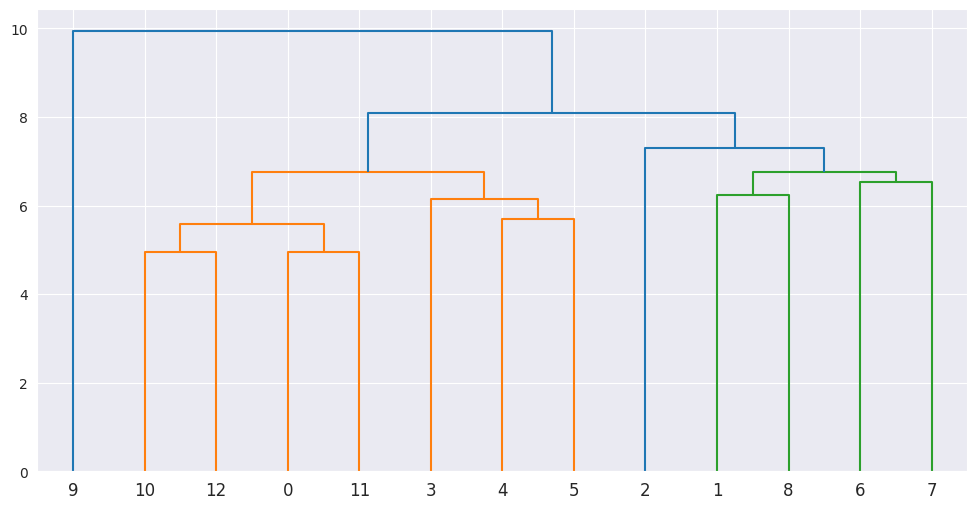

In [26]:
plot_dendrogram(model)

In [27]:
def hierarchical_risk_parity(portfolio):
    portfolio_arr = portfolio.to_numpy().T

    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(portfolio_arr)
    samples_count = len(portfolio.columns)

    subsets = {}
    weights = {}
    
    bisections = model.children_.tolist()
    clusters_count = len(bisections) + samples_count - 1

    def get_subset(index):
        if index < samples_count:
            return [index]
        else:
            return subsets[index]

    for i in range(len(bisections)):
        bisection = bisections[i]
        new_index = samples_count + i

        subsets[new_index] = get_subset(bisection[0]) + get_subset(bisection[1])

    bisections.reverse()
    weights[clusters_count] = 1 

    for i in range(len(bisections)):
        bisection = bisections[i]
        weight = weights[clusters_count - i]

        v1 = np.var(portfolio_arr[get_subset(bisection[0])])
        v2 = np.var(portfolio_arr[get_subset(bisection[1])])

        a1 = 1 - v1 / (v1 + v2)
        a2 = 1 - a1

        weights[bisection[0]] = a1 * weight
        weights[bisection[1]] = a2 * weight
    
    return np.array(list(map(lambda n: weights[n], range(0, samples_count))))

In [28]:
hrp_weights = hierarchical_risk_parity(portfolio)
hrp_weights

array([0.11178502, 0.00488192, 0.03369707, 0.02118932, 0.09744714,
       0.03754443, 0.00335354, 0.06813955, 0.01427346, 0.03886604,
       0.40492215, 0.13184692, 0.03205344])

In [29]:
hrp_portfolio = build_portfolio(INITIAL_FUND, hrp_weights)
hrp_portfolio

array([ 99,   0,   3,  23,  34,  22,   0,  18,   2,   0, 444, 127,  25],
      dtype=int32)

In [50]:
print_weights(hrp_portfolio, portfolio.columns)

Recommended investment in BPT is 99 shares.
Recommended investment in DAC is 0 shares.
Recommended investment in COP is 3 shares.
Recommended investment in STOK is 23 shares.
Recommended investment in COFS is 34 shares.
Recommended investment in VYX is 22 shares.
Recommended investment in HXL is 0 shares.
Recommended investment in CHT is 18 shares.
Recommended investment in FTNT is 2 shares.
Recommended investment in LRCX is 0 shares.
Recommended investment in EVM is 444 shares.
Recommended investment in METC is 127 shares.
Recommended investment in DZSI is 25 shares.


In [30]:
test_portfolio(hrp_portfolio, hrp_weights)

Initial: 9450.400980949402 End: 8839.480271458626 Ratio: 0.9353550488786347
Expected: (0.5834302678681009, 0.4386831645428727)
 Actual: (-0.07580956709183449, 0.16412228951901237)


#### Based on Risk-Parity portfolio optimization technique, which is used to distribute weights across portfolio values to minimize the overall risk. We got decrease in portfolio value, having 0.57% returns as expected, but actually got -0.08. This may indicate that historical variance may not impact current raises and falls for specific businesses always, in respect to dynamic and unpredicted market changes, and that HRP approach performed worse for us.

### 3 - Monte-Carlo modelling

In [31]:
def max_sharpe_monte_carlo(mean_returns, cov_matrix, iterations, risk_free = 0):
    num_assets = len(mean_returns)
    
    best_weights = None
    best_sharpe = 0

    for _ in range(iterations):
        weights = np.array(np.random.random(num_assets))
        # Rebalance Weights
        weights = weights / np.sum(weights)
    
        sharpe_index = sharpe(weights, mean_returns, cov_matrix, risk_free)
        if best_weights is None or best_sharpe < sharpe_index:
            best_weights = weights

    return best_weights

In [32]:
monte_carlo_weights = max_sharpe_monte_carlo(mean_returns, cov_matrix, 5000)
monte_carlo_weights

array([0.092237  , 0.0710247 , 0.02406312, 0.06710341, 0.14300006,
       0.09353621, 0.04139599, 0.13833305, 0.05675332, 0.05697821,
       0.0900559 , 0.08310004, 0.04241899])

In [33]:
monte_carlo_portfolio = build_portfolio(INITIAL_FUND, monte_carlo_weights)
monte_carlo_portfolio

array([82, 12,  2, 74, 50, 55,  5, 37,  9,  1, 98, 80, 33], dtype=int32)

In [51]:
print_weights(monte_carlo_portfolio, portfolio.columns)

Recommended investment in BPT is 82 shares.
Recommended investment in DAC is 12 shares.
Recommended investment in COP is 2 shares.
Recommended investment in STOK is 74 shares.
Recommended investment in COFS is 50 shares.
Recommended investment in VYX is 55 shares.
Recommended investment in HXL is 5 shares.
Recommended investment in CHT is 37 shares.
Recommended investment in FTNT is 9 shares.
Recommended investment in LRCX is 1 shares.
Recommended investment in EVM is 98 shares.
Recommended investment in METC is 80 shares.
Recommended investment in DZSI is 33 shares.


In [34]:
test_portfolio(monte_carlo_portfolio, monte_carlo_weights)

Initial: 9799.667016029358 End: 8950.08006465435 Ratio: 0.9133045082057039
Expected: (0.8163612336777789, 0.5193019484321543)
 Actual: (-0.11495971739160149, 0.1708249661739967)


#### With Monte-Carlo approach, weights chosen are based on the simulation, aiming for the highest Sharpe ratio. Initially, random weights are chosen, then they are updated based on sharpe across iterations. Similar to the previous analyses, the portfolio value decreased, and the actual returns were negative during the testing period. The Monte Carlo optimization results in a portfolio with performance similar to the HRP model, indicating that both approaches may face challenges in the similar testing conditions.